# 10X genomics data

This tutorials shows how to annotate pathway data from a 10x Genomics Single-Cell dataset. In this tutorial, the data being used is the same in the scanpy [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial.

In [1]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

mkdir: cannot create directory ‘data’: File exists
--2021-08-03 19:25:10--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2606:4700::6812:ad, 2606:4700::6812:1ad, 104.18.0.173, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:ad|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-08-03 19:25:10--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:ad|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7,3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7,27M  3,45MB/s    in 2,1s    



In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

## Following scanpy tutorial

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  
    var_names='gene_symbols',                
    cache=True)                              

In [4]:
adata.var_names_make_unique()  

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/joao/miniconda3/envs/descartes-rpa/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [7]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [8]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

## Reactome pathway analysis

Here is where the pathway annotation occurs. You can map pathway activity to each Single-Cell cluster found.

In [9]:
from descartes_rpa import get_pathways_for_group

In [10]:
get_pathways_for_group(adata, groupby="leiden")

In [11]:
from descartes_rpa.pl import marker_genes

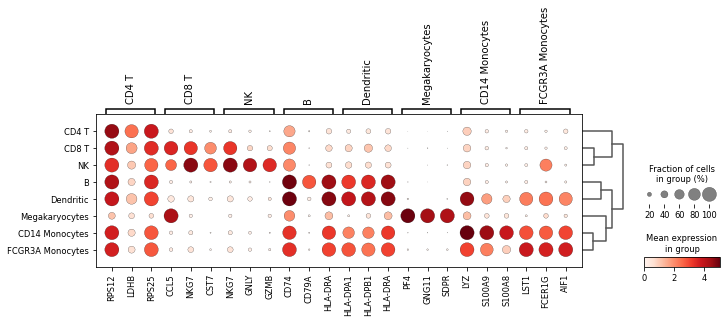

In [12]:
marker_genes(adata, n_genes=3)

### Now, we can use pathways plotting to check pathways shared between the clusters

In [13]:
from descartes_rpa.pl import shared_pathways

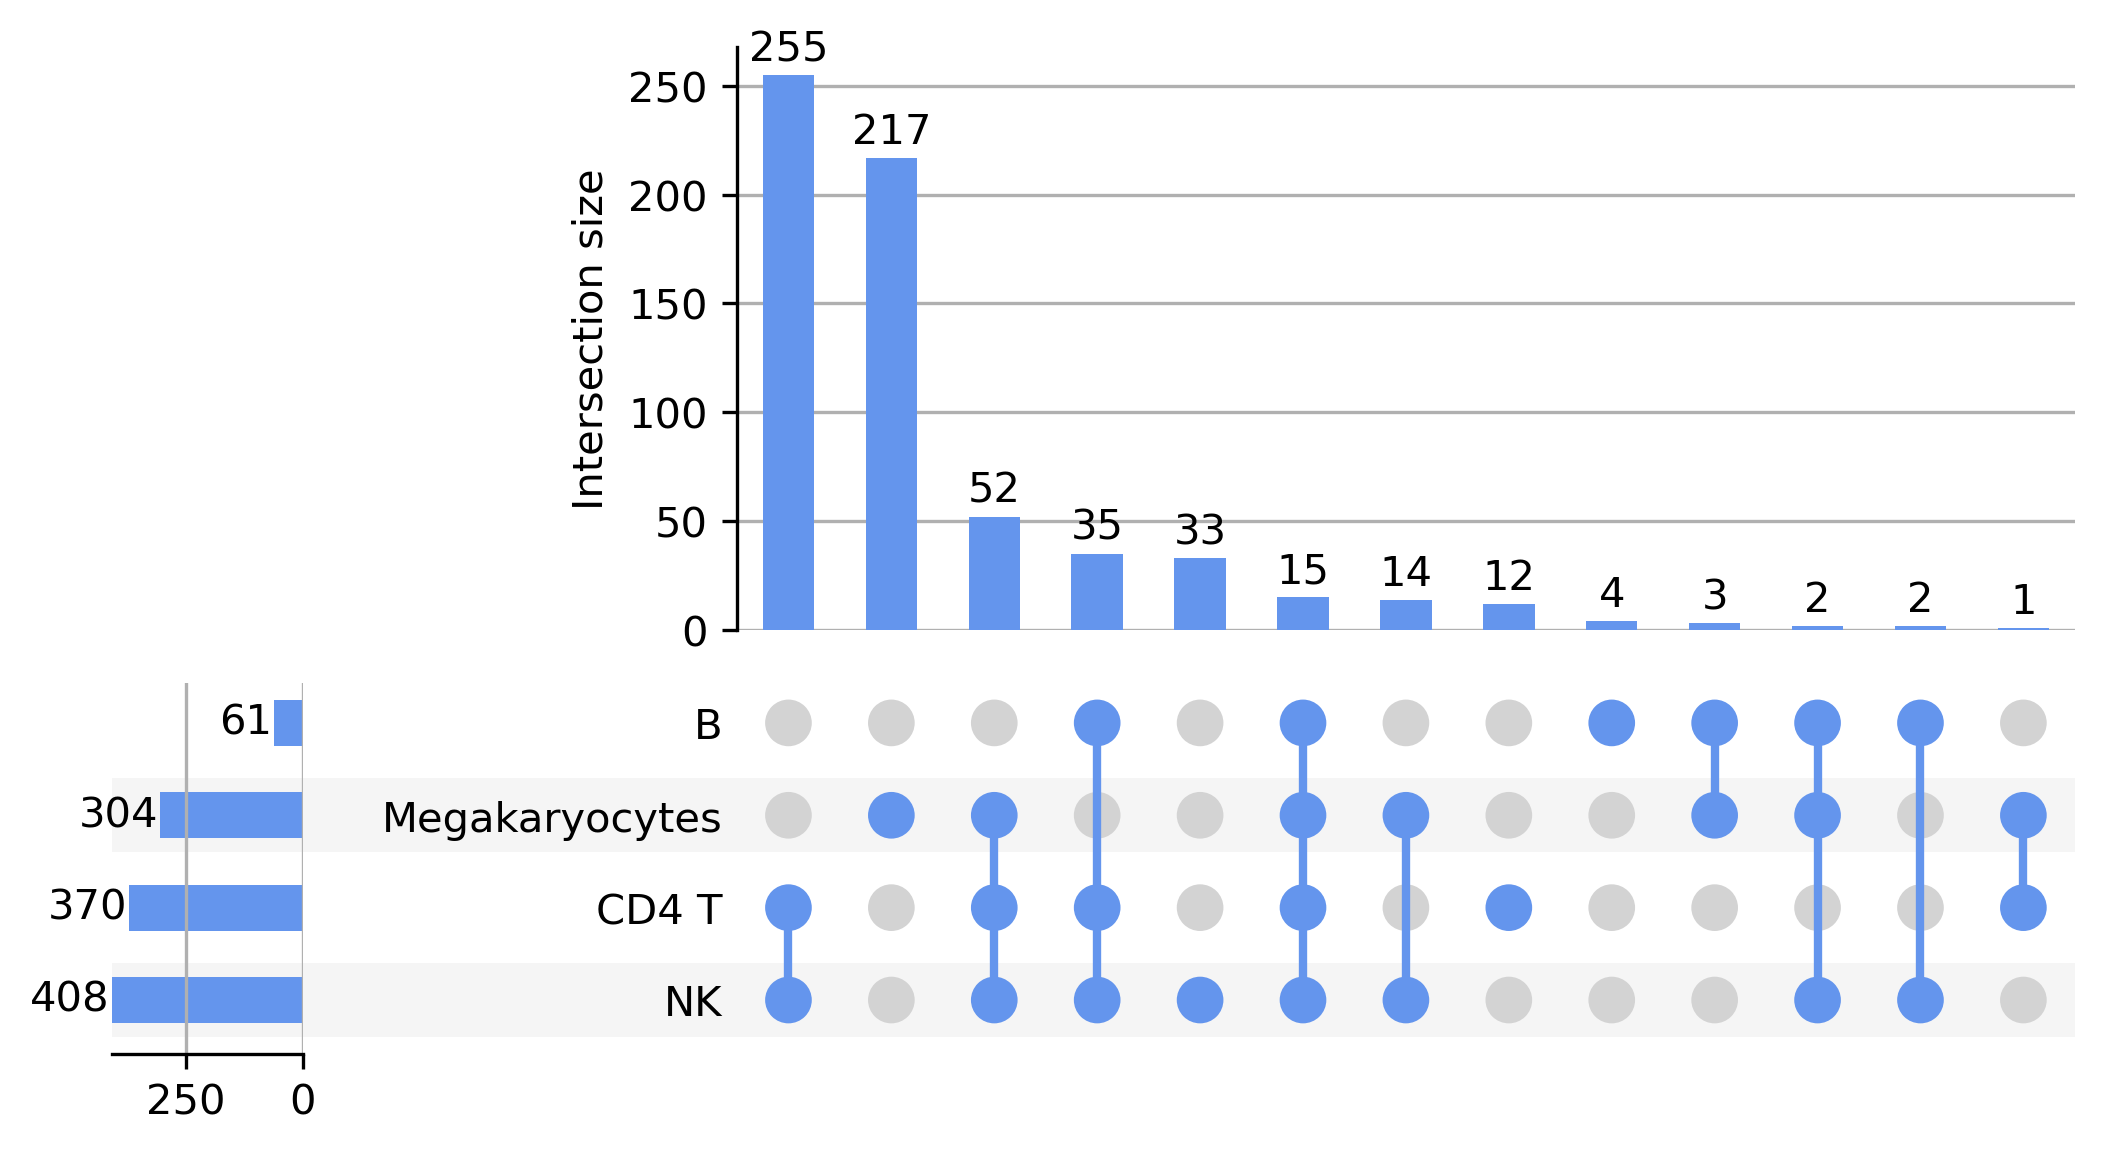

In [14]:
shared_pathways(adata, clusters=["B", "NK", "CD4 T", "Megakaryocytes"])

In [15]:
from descartes_rpa import get_shared

In [16]:
get_shared(adata, clusters=["B", "NK", "CD4 T", "Megakaryocytes"])

,stId,name
0,R-HSA-1280218,Adaptive Immune System
1,R-HSA-168256,Immune System
2,R-HSA-1280215,Cytokine Signaling in Immune system
3,R-HSA-422475,Axon guidance
4,R-HSA-983705,Signaling by the B Cell Receptor (BCR)
5,R-HSA-9675108,Nervous system development
6,R-HSA-71291,Metabolism of amino acids and derivatives
7,R-HSA-8953854,Metabolism of RNA
8,R-HSA-2262752,Cellular responses to stress
9,R-HSA-8953897,Cellular responses to stimuli


You can also plot shared pathways between all clusters. However, this doesn't look good on Jupyter Notebook. This plot creates a PNG file with 300 dpi where you can visualize it better.

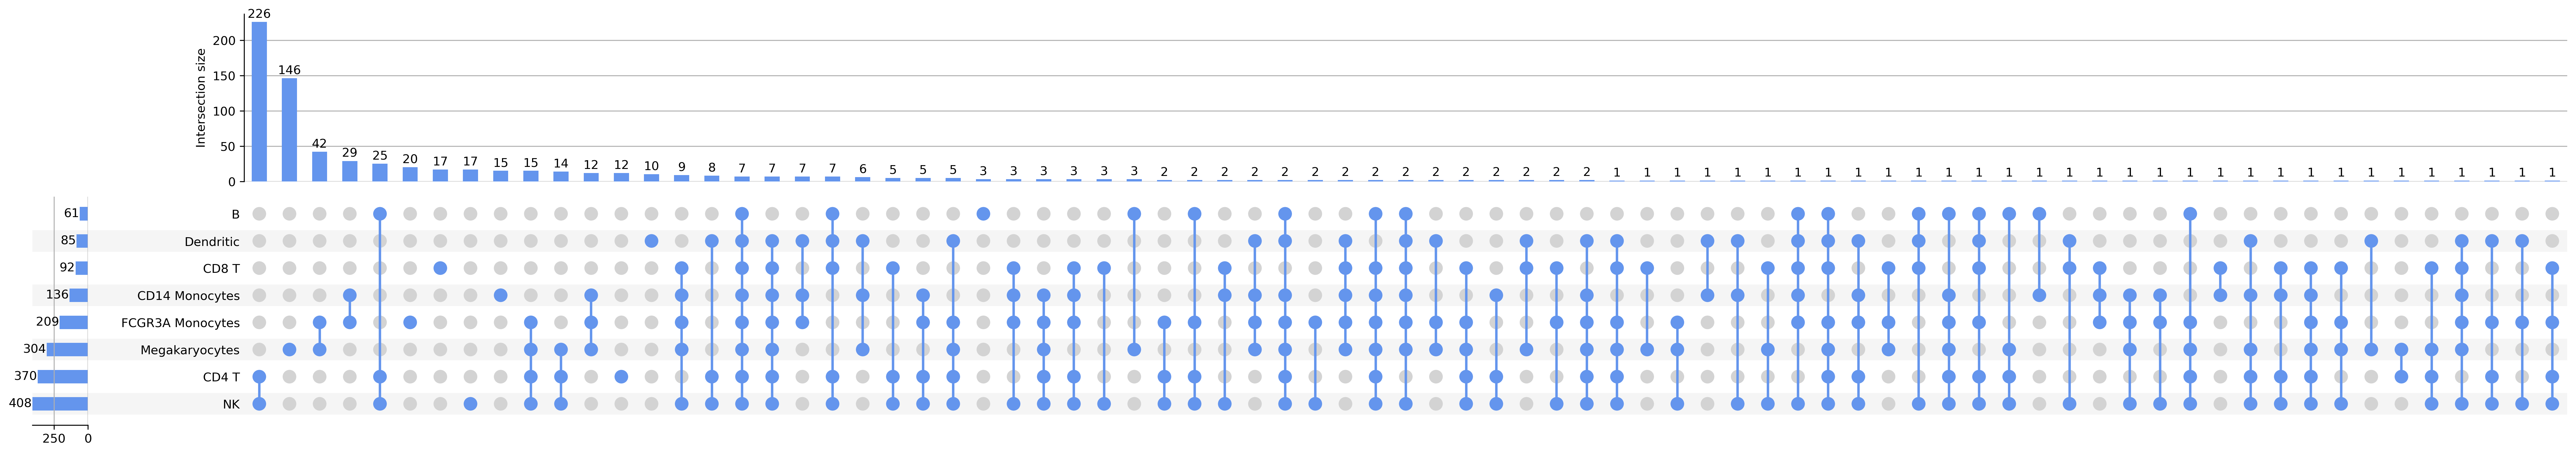

In [17]:
shared_pathways(adata, file_name="all_clusters.png")

Another functionality is to look which pathways were annotated in each clusters. Below you can see an example on the "Megakaryocytes" cluster

In [18]:
from descartes_rpa.pl import pathways

In [19]:
pathways(adata, "Megakaryocytes")

,stId,dbId,name,species,llp,entities,reactions,inDisease
0,R-HSA-76002,76002,"Platelet activation, signaling and aggregation","{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",False,"{'resource': 'TOTAL', 'total': 291, 'found': 8...","{'resource': 'TOTAL', 'total': 116, 'found': 2...",False
1,R-HSA-114608,114608,Platelet degranulation,"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",True,"{'resource': 'TOTAL', 'total': 139, 'found': 6...","{'resource': 'TOTAL', 'total': 11, 'found': 3,...",False
2,R-HSA-76005,76005,Response to elevated platelet cytosolic Ca2+,"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",True,"{'resource': 'TOTAL', 'total': 146, 'found': 6...","{'resource': 'TOTAL', 'total': 14, 'found': 3,...",False
3,R-HSA-109582,109582,Hemostasis,"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",False,"{'resource': 'TOTAL', 'total': 801, 'found': 1...","{'resource': 'TOTAL', 'total': 334, 'found': 4...",False
4,R-HSA-445355,445355,Smooth Muscle Contraction,"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",True,"{'resource': 'TOTAL', 'total': 49, 'found': 4,...","{'resource': 'TOTAL', 'total': 11, 'found': 7,...",False
5,R-HSA-8936459,8936459,RUNX1 regulates genes involved in megakaryocyt...,"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",True,"{'resource': 'TOTAL', 'total': 78, 'found': 4,...","{'resource': 'TOTAL', 'total': 33, 'found': 22...",False
6,R-HSA-418594,418594,G alpha (i) signalling events,"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",True,"{'resource': 'TOTAL', 'total': 425, 'found': 7...","{'resource': 'TOTAL', 'total': 74, 'found': 32...",False
7,R-HSA-140877,140877,Formation of Fibrin Clot (Clotting Cascade),"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",False,"{'resource': 'TOTAL', 'total': 43, 'found': 3,...","{'resource': 'TOTAL', 'total': 61, 'found': 5,...",False
8,R-HSA-380108,380108,Chemokine receptors bind chemokines,"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",True,"{'resource': 'TOTAL', 'total': 57, 'found': 3,...","{'resource': 'TOTAL', 'total': 19, 'found': 3,...",False
9,R-HSA-5250924,5250924,B-WICH complex positively regulates rRNA expre...,"{'dbId': 48887, 'taxId': '9606', 'name': 'Homo...",True,"{'resource': 'TOTAL', 'total': 62, 'found': 3,...","{'resource': 'TOTAL', 'total': 3, 'found': 2, ...",False
